In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2,l1
# tf.compat.v1.disable_eager_execution()
import warnings


# Train Data

In [2]:
train_df=pd.read_csv("data/clean_data/train_clean.csv")

In [3]:
train_df.head()

,Unnamed: 0,rec_id,text,sentiment,rating,clean_text
0,0,4715,For a movie that gets no respect there sure ar...,pos,9,movie get respect sure lot memorable quote lis...
1,1,12390,Bizarre horror movie filled with famous faces ...,pos,8,bizarre horror movie fill famous face steal cr...
2,2,8329,"A solid, if unremarkable film. Matthau, as Ein...",pos,7,solid remarkable film matthau einstein wonderf...
3,3,9063,It's a strange feeling to sit alone in a theat...,pos,8,strange feeling sit alone theater occupy paren...
4,4,3092,"You probably all already know this by now, but...",pos,10,probably already know additional episode never...


In [4]:
train_df.head()

,Unnamed: 0,rec_id,text,sentiment,rating,clean_text
0,0,4715,For a movie that gets no respect there sure ar...,pos,9,movie get respect sure lot memorable quote lis...
1,1,12390,Bizarre horror movie filled with famous faces ...,pos,8,bizarre horror movie fill famous face steal cr...
2,2,8329,"A solid, if unremarkable film. Matthau, as Ein...",pos,7,solid remarkable film matthau einstein wonderf...
3,3,9063,It's a strange feeling to sit alone in a theat...,pos,8,strange feeling sit alone theater occupy paren...
4,4,3092,"You probably all already know this by now, but...",pos,10,probably already know additional episode never...


# Training and Testing

In [5]:
'''Hyper parameters here are
1. Tokenizer(num_words)
2. max_len of sequences for padding and truncating
3. Model Architecture
4. optimizer
5. Learning rate
6. Batch Size

'''

'Hyper parameters here are\n1. Tokenizer(num_words)\n2. max_len of sequences for padding and truncating\n3. Model Architecture\n4. optimizer\n5. Learning rate\n6. Batch Size\n\n'

In [6]:
test_df=pd.read_csv("data/clean_data/test_clean.csv")

In [7]:
class custom_LSTM:
    def __init__(self,train_df,test_df,tokenizer_func,max_len,optimizer,num_words=5000,batch_size=32):
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer_func=tokenizer_func
        self.num_words=num_words
        self.max_len=max_len
        self.optimizer=optimizer
        self.batch_size=batch_size
    
    def get_sequences(self,data,is_train=False):
        if(is_train):
            tokenizer = self.tokenizer_func(num_words=self.num_words, oov_token='<OOV>')
            tokenizer.fit_on_texts(data)
            self.tokenizer=tokenizer
        sequences = self.tokenizer.texts_to_sequences(data)
        padded_sequences = np.array(pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post'))
        
        return padded_sequences
    
    
    def train(self,model_type,epochs=10,is_raw=False):
        
        
        if(model_type=='xs'):
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=64, input_length=self.max_len),
            tf.keras.layers.LSTM(16,return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='s'):
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=128, input_length=self.max_len),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='m'):
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=384, input_length=self.max_len),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='l'):
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=768, input_length=self.max_len),
            tf.keras.layers.LSTM(384, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
            
        ])
            
         
        
        else:
            print("please enter a valid model type s/m/l; choose one")
            return
        
        self.is_raw=is_raw
        
        if(is_raw):
            train_sequences=self.get_sequences(self.train_df['text'].tolist(),is_train=True)
        else:
            train_sequences=self.get_sequences(self.train_df['clean_text'].tolist(),is_train=True)
        
            
            
            
        
        y_train=np.array(self.train_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        
        combined_data = list(zip(train_sequences, y_train))
        
        np.random.seed(12)
        
        np.random.shuffle(combined_data)
        
        train_sequences, y_train = zip(*combined_data)
        
        train_sequences=np.array(train_sequences)
        
        y_train=np.array(y_train)

        
        num_validation_samples = int(0.20 * len(train_sequences))
        
        x_train = train_sequences[:-num_validation_samples]
        y_train = y_train[:-num_validation_samples]
        x_val = train_sequences[-num_validation_samples:]
        y_val = y_train[-num_validation_samples:]
        
        
        
        
        
        early_stopping_acc= EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        early_stopping_loss= EarlyStopping(monitor='val_loss', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        history=model.fit(x_train, y_train, epochs=epochs, batch_size=self.batch_size, validation_data=(x_val, y_val),shuffle=False,callbacks=[early_stopping_acc,early_stopping_loss])
        
        
        
        if early_stopping_acc.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_acc.stopped_epoch + 1}, based on the validation accuracy.')
        if early_stopping_loss.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_loss.stopped_epoch + 1}, based on the validation loss.')
        
        self.model=model
        
        self.training_accuracy = history.history['accuracy']
        self.validation_accuracy = history.history['val_accuracy']
        
        self.training_loss = history.history['loss']
        self.validation_loss = history.history['val_loss']
        
        
        
        model.save('data/LSTM_models/model_type_'+str(model_type)+'_'+'epochs_'+
              str(epochs)+'_'+str(self.num_words)+'_'+str(self.max_len)+'_'+str('adam')+'_'+str(is_raw))
        
        
    def evaluate(self):
        
        if(self.is_raw):
            test_sequences=self.get_sequences(self.test_df['text'].tolist(),is_train=False)
        else:
            test_sequences=self.get_sequences(self.test_df['clean_text'].tolist(),is_train=False)
        
        y_test=np.array(self.test_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        predictions = self.model.predict(test_sequences)
        
        binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
        
        accuracy_lstm = accuracy_score(y_test, binary_predictions)
        
        print("Accuracy (LSTM):", accuracy_lstm)
        
        
        confusion_matrix_lstm = confusion_matrix(y_test, binary_predictions)
        
        print("Confusion Matrix (LSTM):\n", confusion_matrix_lstm)
        
        
        classification_report_lstm = classification_report(y_test, binary_predictions)
        
        print("Classification Report (LSTM):\n", classification_report_lstm)
        
        
        
        
        

# Different Models

In [8]:
# num_words=500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=500,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

2023-11-10 03:23:04.660511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:23:04.660948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:23:04.661691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:23:06.441703: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-10 03:23:06.534874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:23:06.535416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:23:06.535906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

40/40 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7460

2023-11-10 03:23:19.479335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:23:19.479781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:23:19.480438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 14s 335ms/step - loss: 0.5051 - accuracy: 0.7460 - val_loss: 0.7832 - val_accuracy: 0.4978
Epoch 2/100
40/40 [==============================] - 15s 375ms/step - loss: 0.4033 - accuracy: 0.8263 - val_loss: 0.7509 - val_accuracy: 0.5008
Epoch 3/100
40/40 [==============================] - 19s 466ms/step - loss: 0.3959 - accuracy: 0.8272 - val_loss: 0.8991 - val_accuracy: 0.5008
Epoch 4/100
40/40 [==============================] - 19s 469ms/step - loss: 0.3887 - accuracy: 0.8294 - val_loss: 0.7521 - val_accuracy: 0.4896
Epoch 5/100
40/40 [==============================] - 17s 428ms/step - loss: 0.3854 - accuracy: 0.8298 - val_loss: 0.7778 - val_accuracy: 0.4968
Epoch 6/100
40/40 [==============================] - 16s 391ms/step - loss: 0.3770 - accuracy: 0.8350 - val_loss: 0.9020 - val_accuracy: 0.4922
Epoch 7/100
40/40 [==============================] - 18s 445ms/step - loss: 0.3708 - accuracy: 0.8376 - val_loss: 0.8773 - val_accuracy: 0.4962
Epoc

2023-11-10 03:25:39.573901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:25:39.574895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:25:39.575454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 03:25:40.580394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:25:40.581043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:25:40.581633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_500_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_500_150_adam_False/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          64000     
                                                                 
 lstm (LSTM)                 (None, 150, 64)           49408     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0

2023-11-10 03:25:42.595486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:25:42.595937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:25:42.596514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 16s 20ms/step
Accuracy (LSTM): 0.79812
Confusion Matrix (LSTM):
 [[ 8442  4058]
 [  989 11511]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.90      0.68      0.77     12500
           1       0.74      0.92      0.82     12500

    accuracy                           0.80     25000
   macro avg       0.82      0.80      0.80     25000
weighted avg       0.82      0.80      0.80     25000



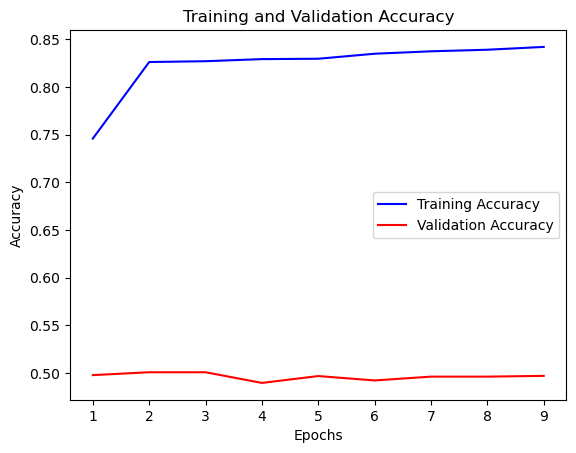

In [9]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

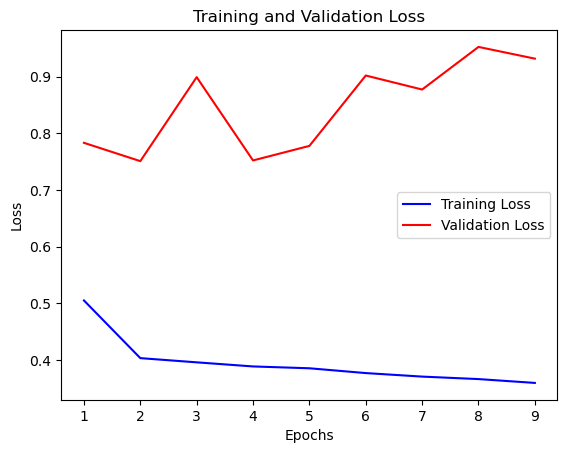

In [10]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
# num_words=750,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=750,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 03:25:58.501566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:25:58.504118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:25:58.504621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:26:00.980872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:26:00.981485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:26:00.982039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.7610

2023-11-10 03:26:17.882477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:26:17.883124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:26:17.883814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 18s 440ms/step - loss: 0.4848 - accuracy: 0.7610 - val_loss: 0.7309 - val_accuracy: 0.4974
Epoch 2/100
40/40 [==============================] - 17s 417ms/step - loss: 0.3743 - accuracy: 0.8407 - val_loss: 0.7534 - val_accuracy: 0.5014
Epoch 3/100
40/40 [==============================] - 16s 405ms/step - loss: 0.3619 - accuracy: 0.8474 - val_loss: 0.8620 - val_accuracy: 0.5010
Epoch 4/100
40/40 [==============================] - 20s 507ms/step - loss: 0.3580 - accuracy: 0.8475 - val_loss: 0.7807 - val_accuracy: 0.5000
Epoch 5/100
40/40 [==============================] - 22s 546ms/step - loss: 0.3506 - accuracy: 0.8510 - val_loss: 0.8866 - val_accuracy: 0.4984
Epoch 6/100
40/40 [==============================] - 22s 537ms/step - loss: 0.3388 - accuracy: 0.8561 - val_loss: 0.9514 - val_accuracy: 0.5006
Epoch 7/100
40/40 [==============================] - 23s 567ms/step - loss: 0.3333 - accuracy: 0.8578 - val_loss: 0.8901 - val_accuracy: 0.4988
Epoc

2023-11-10 03:28:40.464992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:28:40.468370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:28:40.469646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 03:28:41.729426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,128]
	 [[{{node inputs_0}}]]
2023-11-10 03:28:41.738737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,128]
	 [[{{node inputs}}]]
2023-11-10 03:28:41.744071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,128]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_750_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_750_150_adam_False/assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          96000     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           49408     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)               

2023-11-10 03:28:44.054781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:28:44.055929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:28:44.056613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 28s 35ms/step
Accuracy (LSTM): 0.72476
Confusion Matrix (LSTM):
 [[ 5944  6556]
 [  325 12175]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.95      0.48      0.63     12500
           1       0.65      0.97      0.78     12500

    accuracy                           0.72     25000
   macro avg       0.80      0.72      0.71     25000
weighted avg       0.80      0.72      0.71     25000



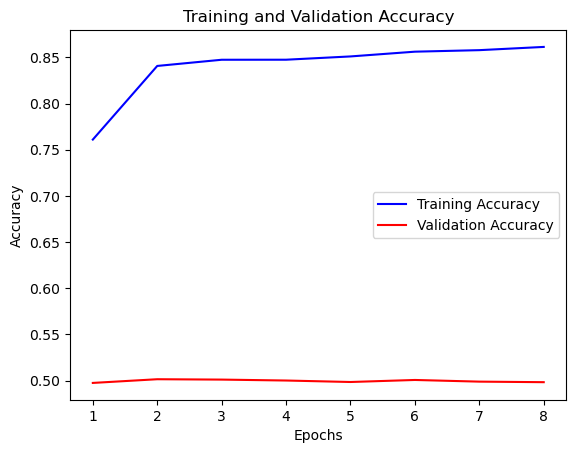

In [12]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

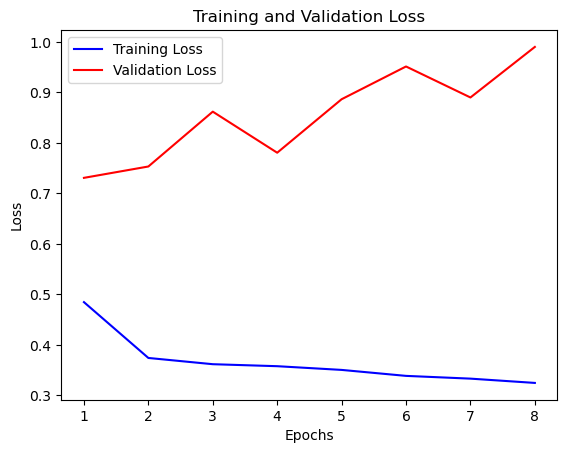

In [13]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# num_words=1000,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=1000,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 03:29:12.114142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:29:12.114830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:29:12.115247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:29:15.836565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:29:15.837191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:29:15.845088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.7641

2023-11-10 03:29:35.871874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:29:35.872629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:29:35.873677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 22s 511ms/step - loss: 0.4838 - accuracy: 0.7641 - val_loss: 0.7024 - val_accuracy: 0.4904
Epoch 2/100
40/40 [==============================] - 18s 456ms/step - loss: 0.3574 - accuracy: 0.8489 - val_loss: 0.7146 - val_accuracy: 0.4944
Epoch 3/100
40/40 [==============================] - 18s 456ms/step - loss: 0.3375 - accuracy: 0.8579 - val_loss: 0.7341 - val_accuracy: 0.4980
Epoch 4/100
40/40 [==============================] - 22s 547ms/step - loss: 0.3326 - accuracy: 0.8561 - val_loss: 0.7696 - val_accuracy: 0.4976
Epoch 5/100
40/40 [==============================] - 21s 527ms/step - loss: 0.3207 - accuracy: 0.8633 - val_loss: 0.8132 - val_accuracy: 0.4962
Epoch 6/100
40/40 [==============================] - 22s 554ms/step - loss: 0.3083 - accuracy: 0.8692 - val_loss: 0.9098 - val_accuracy: 0.4998
Epoch 7/100
40/40 [==============================] - 21s 512ms/step - loss: 0.2963 - accuracy: 0.8737 - val_loss: 0.9593 - val_accuracy: 0.4998
Epoc

2023-11-10 03:32:01.084730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:32:01.085394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:32:01.086067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 03:32:02.247546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:32:02.250719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:32:02.254849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_1000_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_1000_150_adam_False/assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 128)          128000    
                                                                 
 lstm_2 (LSTM)               (None, 150, 64)           49408     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)               

2023-11-10 03:32:05.822331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:32:05.823378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:32:05.823963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 27s 35ms/step
Accuracy (LSTM): 0.83044
Confusion Matrix (LSTM):
 [[ 9684  2816]
 [ 1423 11077]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.87      0.77      0.82     12500
           1       0.80      0.89      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



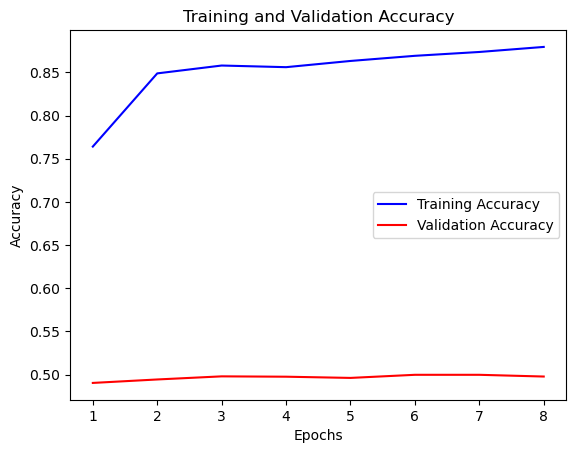

In [15]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

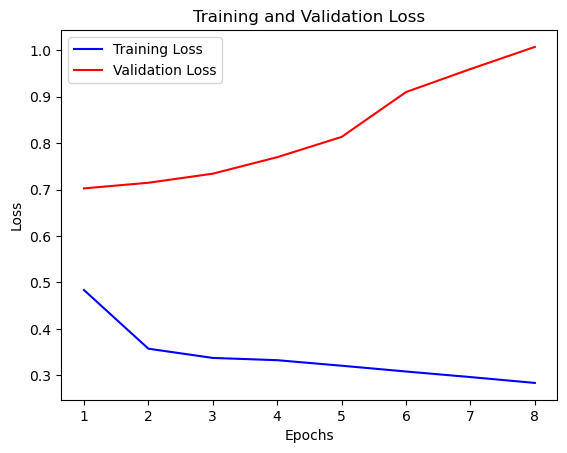

In [16]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# num_words=2500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=2500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 03:32:33.927178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:32:33.928249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:32:33.928783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:32:38.012459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:32:38.013004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:32:38.013637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.7745

2023-11-10 03:33:44.108156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:33:44.108667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:33:44.109319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 73s 2s/step - loss: 0.4650 - accuracy: 0.7745 - val_loss: 0.7488 - val_accuracy: 0.5020
Epoch 2/100
40/40 [==============================] - 88s 2s/step - loss: 0.2953 - accuracy: 0.8790 - val_loss: 0.7855 - val_accuracy: 0.5018
Epoch 3/100
40/40 [==============================] - 84s 2s/step - loss: 0.2676 - accuracy: 0.8917 - val_loss: 0.9270 - val_accuracy: 0.5038
Epoch 4/100
40/40 [==============================] - 83s 2s/step - loss: 0.2455 - accuracy: 0.9040 - val_loss: 1.1144 - val_accuracy: 0.5076
Epoch 5/100
40/40 [==============================] - 68s 2s/step - loss: 0.2194 - accuracy: 0.9136 - val_loss: 1.1232 - val_accuracy: 0.5022
Epoch 6/100
40/40 [==============================] - 82s 2s/step - loss: 0.1891 - accuracy: 0.9283 - val_loss: 1.1617 - val_accuracy: 0.4980
Epoch 7/100
40/40 [==============================] - 80s 2s/step - loss: 0.1718 - accuracy: 0.9347 - val_loss: 1.4444 - val_accuracy: 0.4998
Epoch 8/100
40/40 [======

2023-11-10 03:43:09.369647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:43:09.370206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:43:09.370769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 03:43:10.719091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:43:10.721525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:43:10.723268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_2500_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_2500_150_adam_False/assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 384)          960000    
                                                                 
 lstm_3 (LSTM)               (None, 150, 256)          656384    
                                                                 
 global_average_pooling1d_3   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)               

2023-11-10 03:43:12.853599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:43:12.854466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:43:12.854994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 96s 122ms/step
Accuracy (LSTM): 0.83224
Confusion Matrix (LSTM):
 [[10738  1762]
 [ 2432 10068]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.82      0.86      0.84     12500
           1       0.85      0.81      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



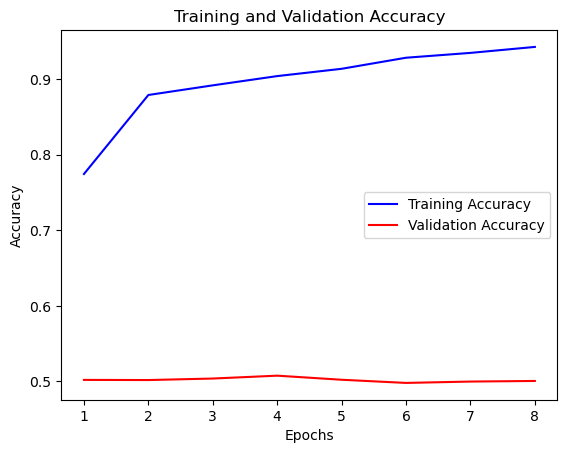

In [18]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

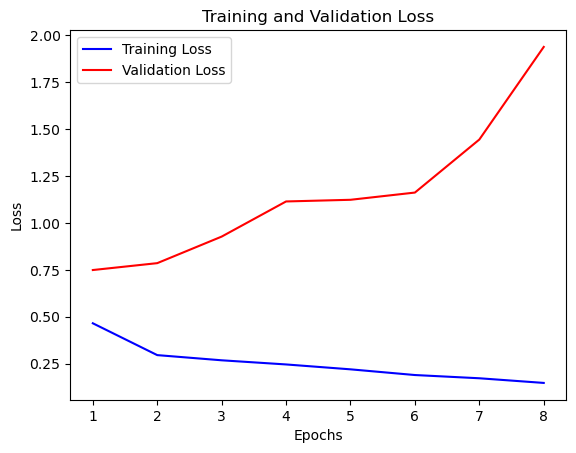

In [19]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# num_words=5000,max_len=150, optimizer=adam,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 03:44:49.181905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:44:49.182889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:44:49.183746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:44:51.658320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:44:51.658826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:44:51.659462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.7529

2023-11-10 03:46:17.944006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:46:17.944573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:46:17.945260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 97s 2s/step - loss: 0.4855 - accuracy: 0.7529 - val_loss: 0.8509 - val_accuracy: 0.5028
Epoch 2/100
40/40 [==============================] - 96s 2s/step - loss: 0.2564 - accuracy: 0.9000 - val_loss: 0.8273 - val_accuracy: 0.5010
Epoch 3/100
40/40 [==============================] - 96s 2s/step - loss: 0.2073 - accuracy: 0.9212 - val_loss: 1.0260 - val_accuracy: 0.4972
Epoch 4/100
40/40 [==============================] - 96s 2s/step - loss: 0.1598 - accuracy: 0.9406 - val_loss: 1.2603 - val_accuracy: 0.4982
Epoch 5/100
40/40 [==============================] - 84s 2s/step - loss: 0.1398 - accuracy: 0.9469 - val_loss: 2.0399 - val_accuracy: 0.4954
Epoch 6/100
40/40 [==============================] - 67s 2s/step - loss: 0.1383 - accuracy: 0.9463 - val_loss: 1.8384 - val_accuracy: 0.4930
Epoch 7/100
40/40 [==============================] - 96s 2s/step - loss: 0.0938 - accuracy: 0.9664 - val_loss: 2.4445 - val_accuracy: 0.4960
Epoch 8/100
40/40 [======

2023-11-10 03:56:56.255410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:56:56.257043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:56:56.257680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 03:56:57.423604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:56:57.424830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:56:57.431952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_False/assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 lstm_4 (LSTM)               (None, 150, 256)          656384    
                                                                 
 global_average_pooling1d_4   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)               

2023-11-10 03:57:00.071991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:57:00.072647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:57:00.073130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 127s 161ms/step
Accuracy (LSTM): 0.79616
Confusion Matrix (LSTM):
 [[11534   966]
 [ 4130  8370]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.74      0.92      0.82     12500
           1       0.90      0.67      0.77     12500

    accuracy                           0.80     25000
   macro avg       0.82      0.80      0.79     25000
weighted avg       0.82      0.80      0.79     25000



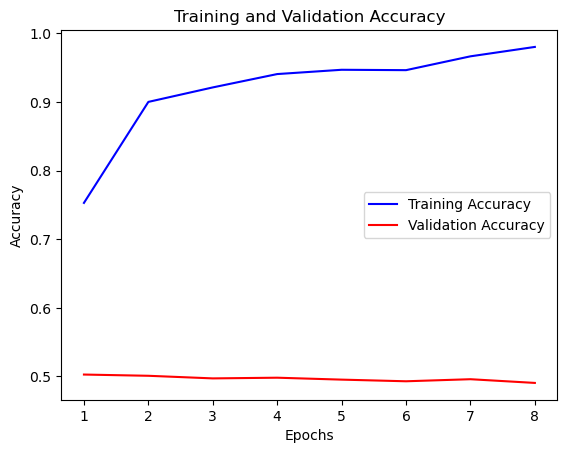

In [21]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

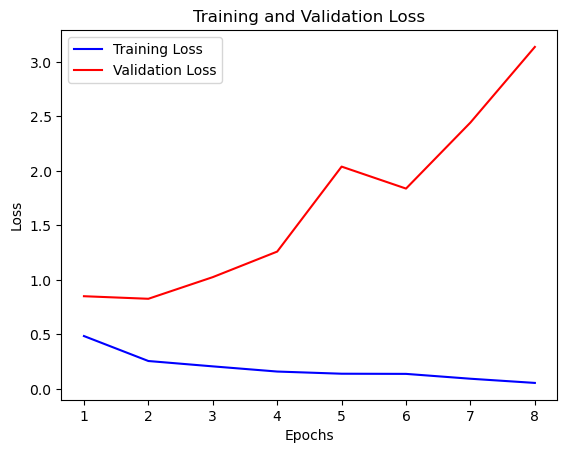

In [22]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
# num_words=5000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 03:59:07.328364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:59:07.329021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:59:07.329811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 03:59:13.286444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 03:59:13.288464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 03:59:13.291157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.7750

2023-11-10 04:00:32.506719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:00:32.507256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:00:32.507998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 85s 2s/step - loss: 0.4607 - accuracy: 0.7750 - val_loss: 0.7039 - val_accuracy: 0.4978
Epoch 2/100
40/40 [==============================] - 66s 2s/step - loss: 0.2804 - accuracy: 0.8857 - val_loss: 0.8232 - val_accuracy: 0.4960
Epoch 3/100
40/40 [==============================] - 88s 2s/step - loss: 0.2276 - accuracy: 0.9108 - val_loss: 1.0269 - val_accuracy: 0.4962
Epoch 4/100
40/40 [==============================] - 86s 2s/step - loss: 0.1754 - accuracy: 0.9355 - val_loss: 1.3073 - val_accuracy: 0.5022
Epoch 5/100
40/40 [==============================] - 86s 2s/step - loss: 0.1631 - accuracy: 0.9354 - val_loss: 1.2436 - val_accuracy: 0.5056
Epoch 6/100
40/40 [==============================] - 87s 2s/step - loss: 0.1315 - accuracy: 0.9485 - val_loss: 2.3742 - val_accuracy: 0.5036
Epoch 7/100
40/40 [==============================] - 86s 2s/step - loss: 0.1331 - accuracy: 0.9489 - val_loss: 2.9633 - val_accuracy: 0.5044
Epoch 8/100
40/40 [======

2023-11-10 04:10:16.891034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:10:16.891622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:10:16.892446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 04:10:18.095264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:10:18.095739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:10:18.096156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_True/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_True/assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 lstm_5 (LSTM)               (None, 150, 256)          656384    
                                                                 
 global_average_pooling1d_5   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 64)               

2023-11-10 04:10:21.274820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:10:21.275322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:10:21.275925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 102s 131ms/step
Accuracy (LSTM): 0.7386
Confusion Matrix (LSTM):
 [[ 6390  6110]
 [  425 12075]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.94      0.51      0.66     12500
           1       0.66      0.97      0.79     12500

    accuracy                           0.74     25000
   macro avg       0.80      0.74      0.72     25000
weighted avg       0.80      0.74      0.72     25000



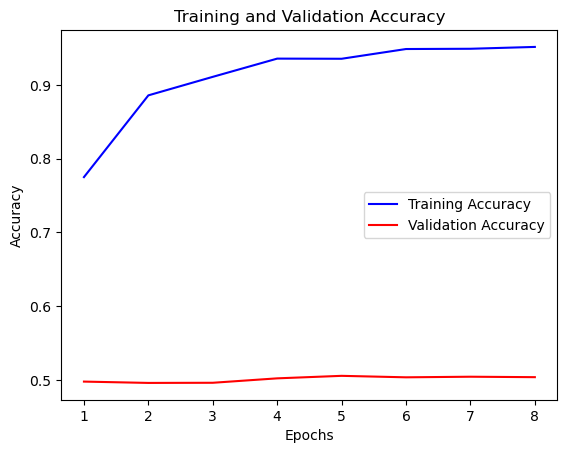

In [24]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

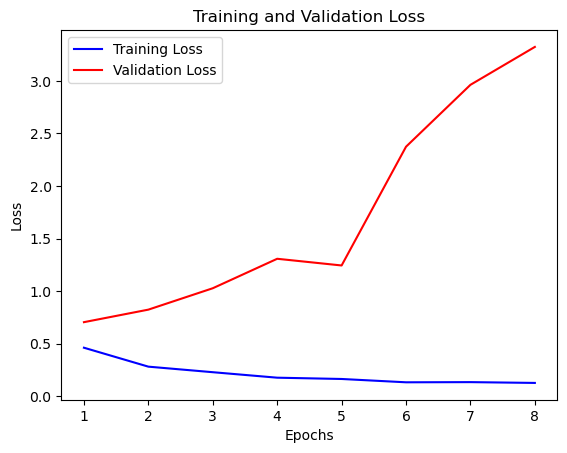

In [25]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
# num_words=7500,max_len=100, optimizer=adam,epochs=100,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 04:12:04.163014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:12:04.163913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:12:04.164308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-10 04:12:07.346335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:12:07.347804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:12:07.350417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.7757

2023-11-10 04:13:02.600959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:13:02.601932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:13:02.603129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 62s 2s/step - loss: 0.4611 - accuracy: 0.7757 - val_loss: 0.8343 - val_accuracy: 0.5020
Epoch 2/100
40/40 [==============================] - 60s 2s/step - loss: 0.2478 - accuracy: 0.9036 - val_loss: 0.8308 - val_accuracy: 0.4962
Epoch 3/100
40/40 [==============================] - 60s 1s/step - loss: 0.1928 - accuracy: 0.9257 - val_loss: 1.0104 - val_accuracy: 0.4988
Epoch 4/100
40/40 [==============================] - 60s 2s/step - loss: 0.1217 - accuracy: 0.9586 - val_loss: 1.4879 - val_accuracy: 0.5018
Epoch 5/100
40/40 [==============================] - 60s 1s/step - loss: 0.1053 - accuracy: 0.9596 - val_loss: 1.5599 - val_accuracy: 0.4986
Epoch 6/100
40/40 [==============================] - 60s 1s/step - loss: 0.1068 - accuracy: 0.9590 - val_loss: 2.0664 - val_accuracy: 0.4960
Epoch 7/100
40/40 [==============================] - 57s 1s/step - loss: 0.0957 - accuracy: 0.9644 - val_loss: 2.7380 - val_accuracy: 0.4958
Epoch 8/100
40/40 [======

2023-11-10 04:19:50.428990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:19:50.430476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:19:50.431535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 04:19:51.279961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:19:51.280519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:19:51.281046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_7500_100_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_7500_100_adam_False/assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 lstm_6 (LSTM)               (None, 100, 256)          656384    
                                                                 
 global_average_pooling1d_6   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64)               

2023-11-10 04:19:53.505619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:19:53.506565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:19:53.507080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 67s 86ms/step
Accuracy (LSTM): 0.78972
Confusion Matrix (LSTM):
 [[10609  1891]
 [ 3366  9134]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.76      0.85      0.80     12500
           1       0.83      0.73      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



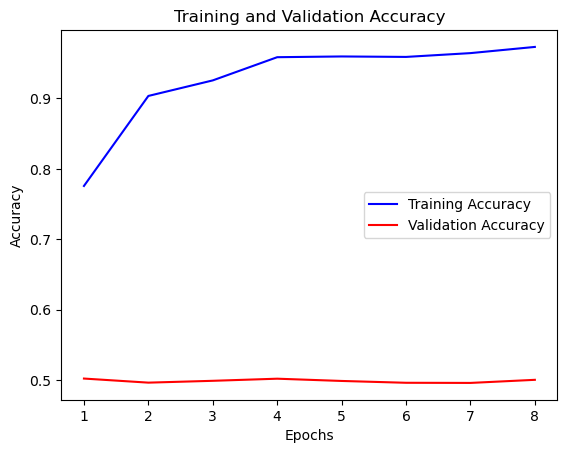

In [27]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

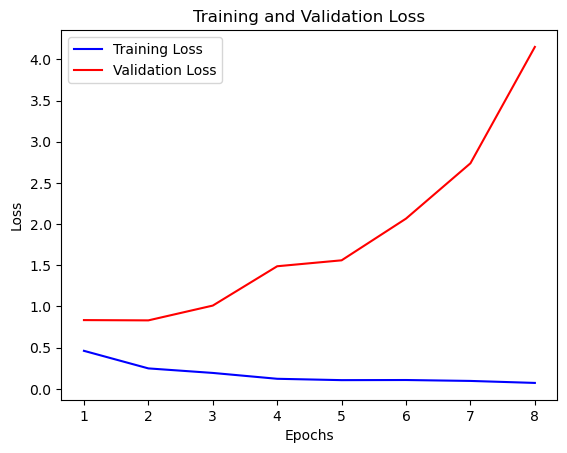

In [28]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
# num_words=7500,max_len=100, optimizer=adam,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 04:21:01.295804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:21:01.296369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:21:01.297583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 04:21:07.338775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:21:07.339392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:21:07.340028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.7777

2023-11-10 04:22:01.040009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:22:01.044565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:22:01.057234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 60s 1s/step - loss: 0.4641 - accuracy: 0.7777 - val_loss: 0.7016 - val_accuracy: 0.4998
Epoch 2/10
40/40 [==============================] - 59s 1s/step - loss: 0.2769 - accuracy: 0.8860 - val_loss: 0.8268 - val_accuracy: 0.4922
Epoch 3/10
40/40 [==============================] - 60s 1s/step - loss: 0.1733 - accuracy: 0.9366 - val_loss: 1.1398 - val_accuracy: 0.5000
Epoch 4/10
40/40 [==============================] - 58s 1s/step - loss: 0.1617 - accuracy: 0.9377 - val_loss: 1.1287 - val_accuracy: 0.4978
Epoch 5/10
40/40 [==============================] - 60s 2s/step - loss: 0.1631 - accuracy: 0.9365 - val_loss: 1.8536 - val_accuracy: 0.5014
Epoch 6/10
40/40 [==============================] - 59s 1s/step - loss: 0.1338 - accuracy: 0.9465 - val_loss: 3.1471 - val_accuracy: 0.5032
Epoch 7/10
40/40 [==============================] - 58s 1s/step - loss: 0.1114 - accuracy: 0.9568 - val_loss: 4.6835 - val_accuracy: 0.5038
Epoch 8/10
40/40 [=============

2023-11-10 04:29:02.470877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:29:02.471398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:29:02.471940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 04:29:03.972340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,384]
	 [[{{node inputs_0}}]]
2023-11-10 04:29:03.981093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,384]
	 [[{{node inputs_0}}]]
2023-11-10 04:29:03.986708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,384]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_10_7500_100_adam_True/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_10_7500_100_adam_True/assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 lstm_7 (LSTM)               (None, 100, 256)          656384    
                                                                 
 global_average_pooling1d_7   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)               

2023-11-10 04:29:07.768757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:29:07.769827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:29:07.770529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 66s 85ms/step
Accuracy (LSTM): 0.65488
Confusion Matrix (LSTM):
 [[ 4173  8327]
 [  301 12199]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.93      0.33      0.49     12500
           1       0.59      0.98      0.74     12500

    accuracy                           0.65     25000
   macro avg       0.76      0.65      0.62     25000
weighted avg       0.76      0.65      0.62     25000



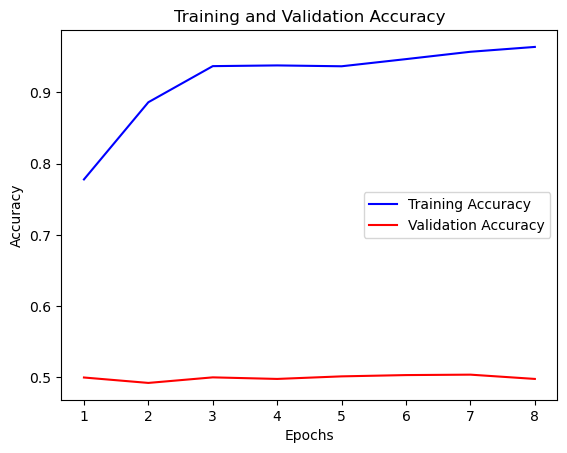

In [30]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

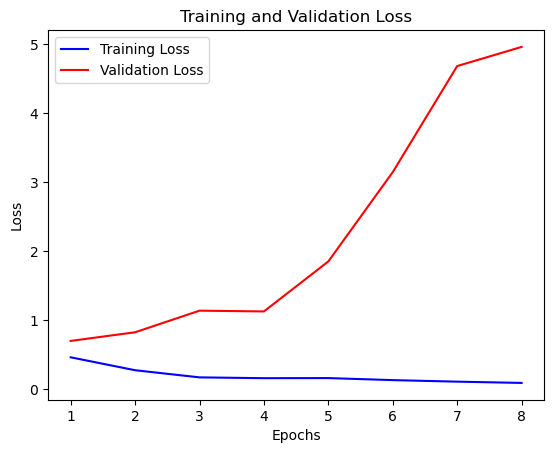

In [31]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
# Large Model

In [33]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 04:30:14.742462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:30:14.742961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:30:14.743376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 04:30:17.919812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:30:17.920912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:30:17.921429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.7452

2023-11-10 04:33:07.247700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:33:07.248509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:33:07.250960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 186s 5s/step - loss: 0.5062 - accuracy: 0.7452 - val_loss: 1.5315 - val_accuracy: 0.4978
Epoch 2/10
40/40 [==============================] - 159s 4s/step - loss: 0.2368 - accuracy: 0.9078 - val_loss: 0.8495 - val_accuracy: 0.4986
Epoch 3/10
40/40 [==============================] - 172s 4s/step - loss: 0.1662 - accuracy: 0.9402 - val_loss: 1.6885 - val_accuracy: 0.4982
Epoch 4/10
40/40 [==============================] - 186s 5s/step - loss: 0.1171 - accuracy: 0.9599 - val_loss: 4.0044 - val_accuracy: 0.4974
Epoch 5/10
40/40 [==============================] - 183s 5s/step - loss: 0.1225 - accuracy: 0.9542 - val_loss: 1.6888 - val_accuracy: 0.4980
Epoch 6/10
40/40 [==============================] - 182s 5s/step - loss: 0.0773 - accuracy: 0.9729 - val_loss: 2.1535 - val_accuracy: 0.5000
Epoch 7/10
40/40 [==============================] - 184s 5s/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 2.4817 - val_accuracy: 0.4964
Epoch 8/10
40/40 [======

2023-11-10 04:53:57.126836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:53:57.127458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:53:57.128172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 04:53:58.037540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:53:58.038174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:53:58.038734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_False/assets


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 lstm_8 (LSTM)               (None, 150, 384)          1771008   
                                                                 
 global_average_pooling1d_8   (None, 384)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128)              

2023-11-10 04:54:00.344893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:54:00.345564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:54:00.346218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 201s 256ms/step
Accuracy (LSTM): 0.61944
Confusion Matrix (LSTM):
 [[12403    97]
 [ 9417  3083]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.57      0.99      0.72     12500
           1       0.97      0.25      0.39     12500

    accuracy                           0.62     25000
   macro avg       0.77      0.62      0.56     25000
weighted avg       0.77      0.62      0.56     25000



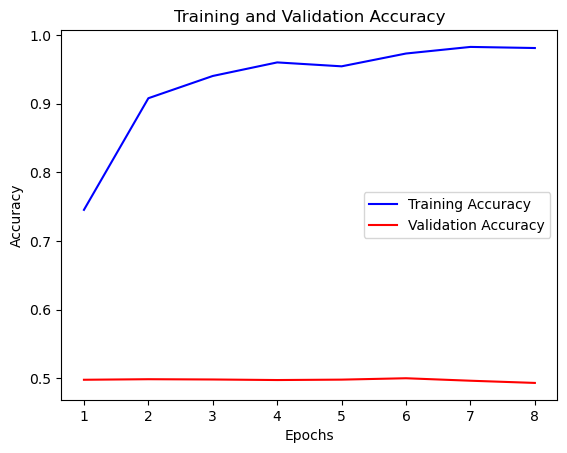

In [34]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

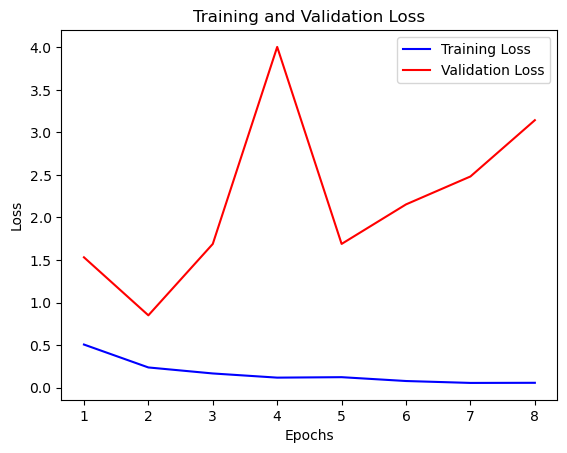

In [35]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 04:57:21.416417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:57:21.416887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:57:21.417502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 04:57:25.023620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:57:25.024378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:57:25.024840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.7804

2023-11-10 04:59:04.894968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 04:59:04.895429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 04:59:04.896121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 109s 3s/step - loss: 0.4748 - accuracy: 0.7804 - val_loss: 0.8610 - val_accuracy: 0.5010
Epoch 2/10
40/40 [==============================] - 107s 3s/step - loss: 0.2468 - accuracy: 0.9050 - val_loss: 0.9271 - val_accuracy: 0.5026
Epoch 3/10
40/40 [==============================] - 105s 3s/step - loss: 0.1977 - accuracy: 0.9302 - val_loss: 1.0416 - val_accuracy: 0.4984
Epoch 4/10
40/40 [==============================] - 105s 3s/step - loss: 0.1490 - accuracy: 0.9498 - val_loss: 1.9960 - val_accuracy: 0.4976
Epoch 5/10
40/40 [==============================] - 106s 3s/step - loss: 0.1116 - accuracy: 0.9614 - val_loss: 2.0304 - val_accuracy: 0.4964
Epoch 6/10
40/40 [==============================] - 106s 3s/step - loss: 0.0925 - accuracy: 0.9682 - val_loss: 3.0098 - val_accuracy: 0.4932
Epoch 7/10
40/40 [==============================] - 105s 3s/step - loss: 0.0645 - accuracy: 0.9794 - val_loss: 3.7880 - val_accuracy: 0.5008
Epoch 8/10
40/40 [======

2023-11-10 05:11:33.742575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:11:33.743055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:11:33.743477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 05:11:34.749325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:11:34.749756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:11:34.750399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_True/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_True/assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 lstm_9 (LSTM)               (None, 150, 384)          1771008   
                                                                 
 global_average_pooling1d_9   (None, 384)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 128)              

2023-11-10 05:11:37.202005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:11:37.202445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:11:37.202983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 183s 233ms/step
Accuracy (LSTM): 0.80068
Confusion Matrix (LSTM):
 [[ 9940  2560]
 [ 2423 10077]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     12500
           1       0.80      0.81      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



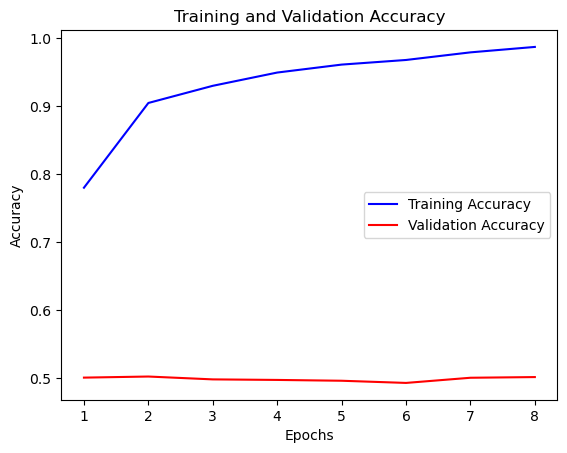

In [37]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

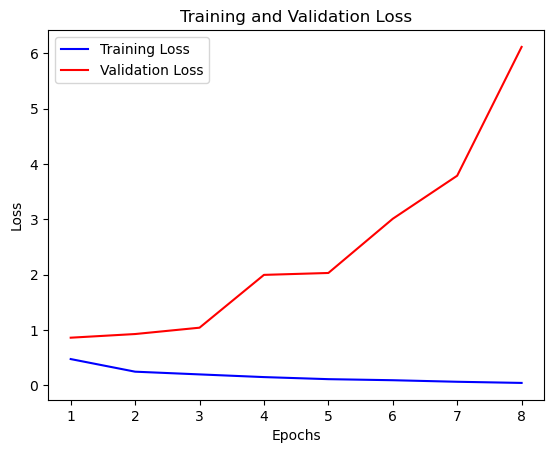

In [38]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 05:14:40.213386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:14:40.214059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:14:40.215154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 05:14:42.212256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:14:42.212901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:14:42.213408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8090

2023-11-10 05:16:34.663015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:16:34.663471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:16:34.663994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 124s 2s/step - loss: 0.4101 - accuracy: 0.8090 - val_loss: 0.8089 - val_accuracy: 0.5020
Epoch 2/10
79/79 [==============================] - 122s 2s/step - loss: 0.1901 - accuracy: 0.9251 - val_loss: 1.9623 - val_accuracy: 0.5030
Epoch 3/10
79/79 [==============================] - 123s 2s/step - loss: 0.1125 - accuracy: 0.9618 - val_loss: 1.5959 - val_accuracy: 0.4930
Epoch 4/10
79/79 [==============================] - 123s 2s/step - loss: 0.0791 - accuracy: 0.9728 - val_loss: 7.5935 - val_accuracy: 0.4964
Epoch 5/10
79/79 [==============================] - 123s 2s/step - loss: 0.0955 - accuracy: 0.9658 - val_loss: 5.8856 - val_accuracy: 0.4988
Epoch 6/10
79/79 [==============================] - 123s 2s/step - loss: 0.0748 - accuracy: 0.9725 - val_loss: 8.4846 - val_accuracy: 0.4992
Epoch 7/10
79/79 [==============================] - 123s 2s/step - loss: 0.0400 - accuracy: 0.9861 - val_loss: 5.5001 - val_accuracy: 0.4958
Epoch 8/10
79/79 [======

2023-11-10 05:31:05.685040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:31:05.685480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:31:05.686083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 05:31:06.455318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:31:06.455753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:31:06.456261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_False/assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 lstm_10 (LSTM)              (None, 150, 384)          1771008   
                                                                 
 global_average_pooling1d_10  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_20 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 128)             

2023-11-10 05:31:08.580501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:31:08.580945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:31:08.581578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 158s 202ms/step
Accuracy (LSTM): 0.53112
Confusion Matrix (LSTM):
 [[  787 11713]
 [    9 12491]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.99      0.06      0.12     12500
           1       0.52      1.00      0.68     12500

    accuracy                           0.53     25000
   macro avg       0.75      0.53      0.40     25000
weighted avg       0.75      0.53      0.40     25000



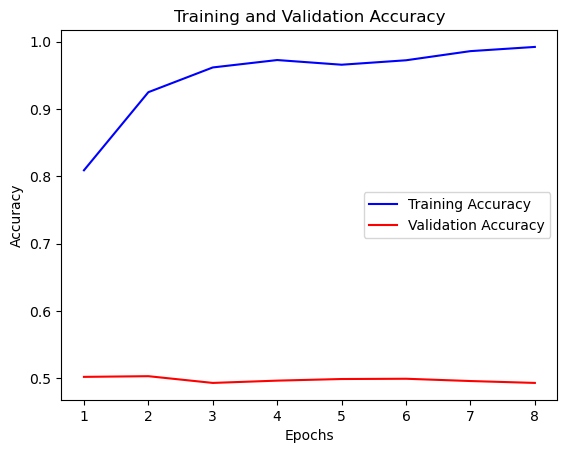

In [40]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

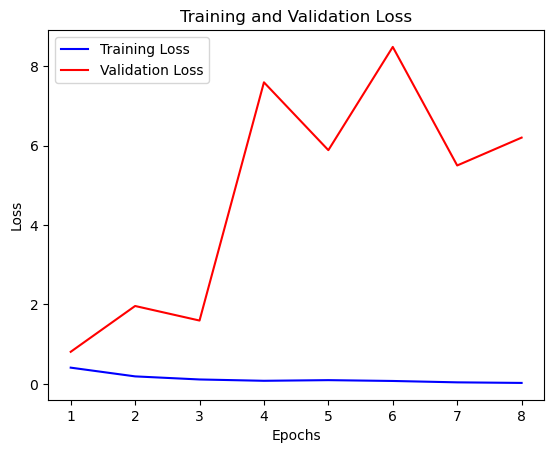

In [41]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 05:33:46.902222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:33:46.902895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:33:46.903398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 05:33:50.496543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:33:50.497018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:33:50.497553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.7978

2023-11-10 05:35:42.589586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:35:42.590034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:35:42.590590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 123s 2s/step - loss: 0.4371 - accuracy: 0.7978 - val_loss: 0.8103 - val_accuracy: 0.5004
Epoch 2/10
79/79 [==============================] - 123s 2s/step - loss: 0.1978 - accuracy: 0.9243 - val_loss: 2.5543 - val_accuracy: 0.4990
Epoch 3/10
79/79 [==============================] - 123s 2s/step - loss: 0.0897 - accuracy: 0.9690 - val_loss: 3.4953 - val_accuracy: 0.5018
Epoch 4/10
79/79 [==============================] - 121s 2s/step - loss: 0.0466 - accuracy: 0.9843 - val_loss: 3.9191 - val_accuracy: 0.4982
Epoch 5/10
79/79 [==============================] - 121s 2s/step - loss: 0.0445 - accuracy: 0.9829 - val_loss: 7.3444 - val_accuracy: 0.4968
Epoch 6/10
79/79 [==============================] - 121s 2s/step - loss: 0.0431 - accuracy: 0.9849 - val_loss: 9.9160 - val_accuracy: 0.4994
Epoch 7/10
79/79 [==============================] - 120s 2s/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 6.3256 - val_accuracy: 0.5002
Epoch 8/10
79/79 [======

2023-11-10 05:52:03.859897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:52:03.860370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:52:03.861068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 05:52:04.771971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,768]
	 [[{{node inputs_0}}]]
2023-11-10 05:52:04.776214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,768]
	 [[{{node inputs_0}}]]
2023-11-10 05:52:04.780292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150,768]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_True/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_True/assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 lstm_11 (LSTM)              (None, 150, 384)          1771008   
                                                                 
 global_average_pooling1d_11  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 128)             

2023-11-10 05:52:07.579476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:52:07.580003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:52:07.580520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 163s 208ms/step
Accuracy (LSTM): 0.75104
Confusion Matrix (LSTM):
 [[ 7112  5388]
 [  836 11664]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.89      0.57      0.70     12500
           1       0.68      0.93      0.79     12500

    accuracy                           0.75     25000
   macro avg       0.79      0.75      0.74     25000
weighted avg       0.79      0.75      0.74     25000



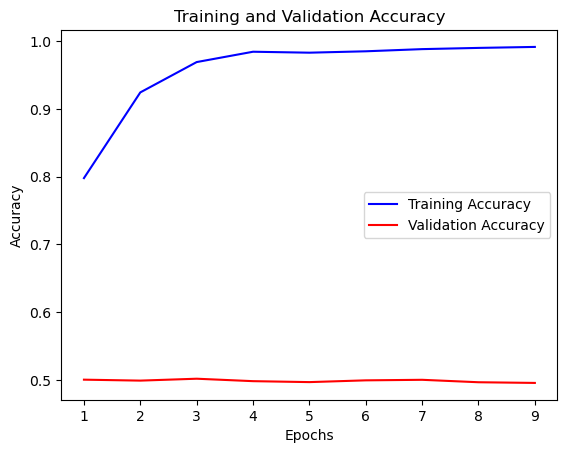

In [43]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

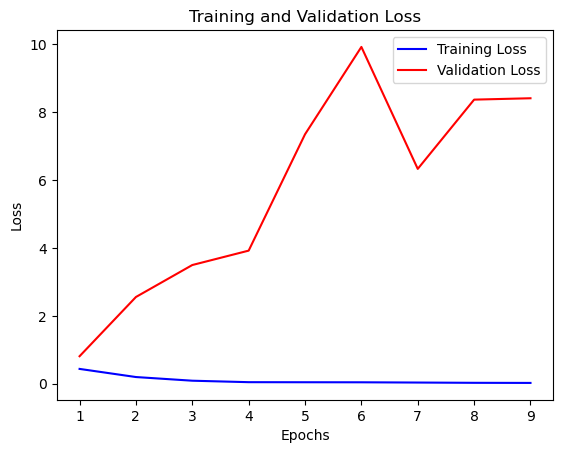

In [44]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [45]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 05:54:50.961984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:54:50.962689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:54:50.963096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 05:54:52.807197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:54:52.807680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:54:52.808247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8193

2023-11-10 05:57:56.160000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 05:57:56.160441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 05:57:56.161080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 208s 1s/step - loss: 0.4010 - accuracy: 0.8193 - val_loss: 0.9391 - val_accuracy: 0.4988
Epoch 2/10
157/157 [==============================] - 209s 1s/step - loss: 0.1844 - accuracy: 0.9319 - val_loss: 2.5880 - val_accuracy: 0.4976
Epoch 3/10
157/157 [==============================] - 208s 1s/step - loss: 0.0935 - accuracy: 0.9688 - val_loss: 8.1863 - val_accuracy: 0.5034
Epoch 4/10
157/157 [==============================] - 209s 1s/step - loss: 0.0612 - accuracy: 0.9782 - val_loss: 5.3547 - val_accuracy: 0.4980
Epoch 5/10
157/157 [==============================] - 206s 1s/step - loss: 0.0495 - accuracy: 0.9826 - val_loss: 41.8583 - val_accuracy: 0.5022
Epoch 6/10
157/157 [==============================] - 206s 1s/step - loss: 0.0409 - accuracy: 0.9858 - val_loss: 12.4765 - val_accuracy: 0.4916
Epoch 7/10
157/157 [==============================] - 203s 1s/step - loss: 0.0436 - accuracy: 0.9844 - val_loss: 10.5345 - val_accuracy: 0.4916
Epoch 8

2023-11-10 06:22:27.485800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:22:27.486232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:22:27.486822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 06:22:28.266749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:22:28.267178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:22:28.267645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_False/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_False/assets


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 lstm_12 (LSTM)              (None, 200, 384)          1771008   
                                                                 
 global_average_pooling1d_12  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 128)             

2023-11-10 06:22:30.341605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:22:30.342039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:22:30.342439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 275s 351ms/step
Accuracy (LSTM): 0.67624
Confusion Matrix (LSTM):
 [[12280   220]
 [ 7874  4626]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.61      0.98      0.75     12500
           1       0.95      0.37      0.53     12500

    accuracy                           0.68     25000
   macro avg       0.78      0.68      0.64     25000
weighted avg       0.78      0.68      0.64     25000



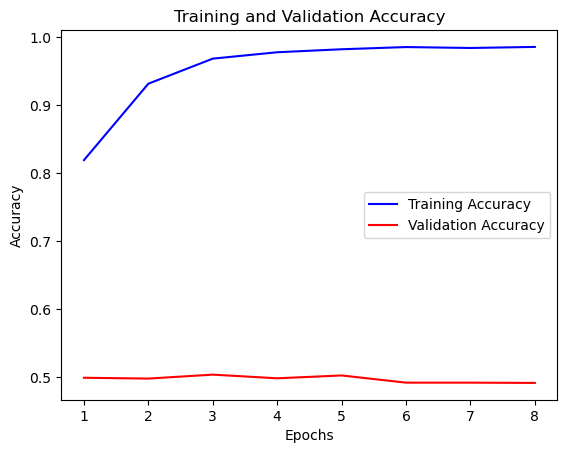

In [46]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

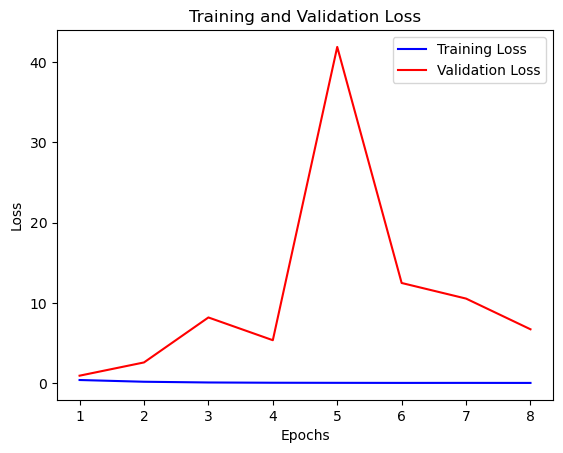

In [47]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_LSTM(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

2023-11-10 06:27:05.305947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:27:05.306555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:27:05.307141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-11-10 06:27:08.913907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:27:08.914386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:27:08.914966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8105

2023-11-10 06:30:04.498415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:30:04.498899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:30:04.499318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 194s 1s/step - loss: 0.4044 - accuracy: 0.8105 - val_loss: 0.7643 - val_accuracy: 0.4948
Epoch 2/10
157/157 [==============================] - 202s 1s/step - loss: 0.1579 - accuracy: 0.9410 - val_loss: 2.1394 - val_accuracy: 0.4972
Epoch 3/10
157/157 [==============================] - 201s 1s/step - loss: 0.0618 - accuracy: 0.9791 - val_loss: 20.3626 - val_accuracy: 0.4978
Epoch 4/10
157/157 [==============================] - 195s 1s/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 4.9062 - val_accuracy: 0.4934
Epoch 5/10
157/157 [==============================] - 202s 1s/step - loss: 0.0412 - accuracy: 0.9855 - val_loss: 4.5351 - val_accuracy: 0.4954
Epoch 6/10
157/157 [==============================] - 197s 1s/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 7.8625 - val_accuracy: 0.4992
Epoch 7/10
157/157 [==============================] - 193s 1s/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 27.4061 - val_accuracy: 0.4976
Epoch 8/

2023-11-10 06:53:27.423221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:53:27.423662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:53:27.424254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-10 06:53:28.374473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:53:28.375145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:53:28.375564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_True/assets


INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_True/assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 lstm_13 (LSTM)              (None, 200, 384)          1771008   
                                                                 
 global_average_pooling1d_13  (None, 384)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_26 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_13 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 128)             

2023-11-10 06:53:31.043281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 06:53:31.043733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 06:53:31.044165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 207s 264ms/step
Accuracy (LSTM): 0.74416
Confusion Matrix (LSTM):
 [[ 6898  5602]
 [  794 11706]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.90      0.55      0.68     12500
           1       0.68      0.94      0.79     12500

    accuracy                           0.74     25000
   macro avg       0.79      0.74      0.73     25000
weighted avg       0.79      0.74      0.73     25000



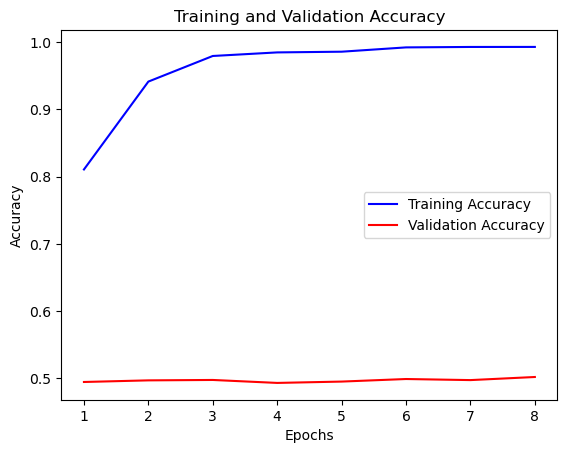

In [49]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

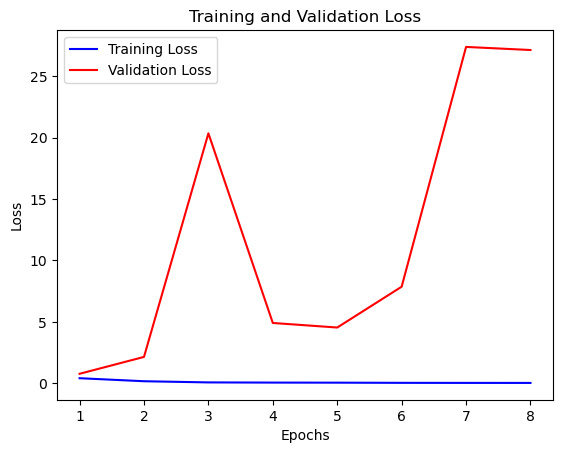

In [50]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Best Accuracy: 0.83224